In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn.metrics import mean_squared_error
import math
import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset = pd.read_csv("The Tata Power Company Limited (TATAPOWER.NS).csv",index_col='Date',parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-24,7.305179,7.623635,6.996374,7.092876,4.329916,391765.0
2000-01-25,7.092876,7.662236,6.986724,7.662236,4.677489,1479196.0
2000-01-26,7.662236,7.662236,7.662236,7.662236,4.677489,0.0
2000-01-27,8.106144,8.106144,7.430632,7.556084,4.612687,1148622.0
2000-01-28,7.527133,8.106144,7.358255,7.889015,4.815927,1659535.0


In [4]:
dataset.isnull().sum()

Open         10
High         10
Low          10
Close        10
Adj Close    10
Volume       10
dtype: int64

In [5]:
dataset = dataset.dropna(how='all')

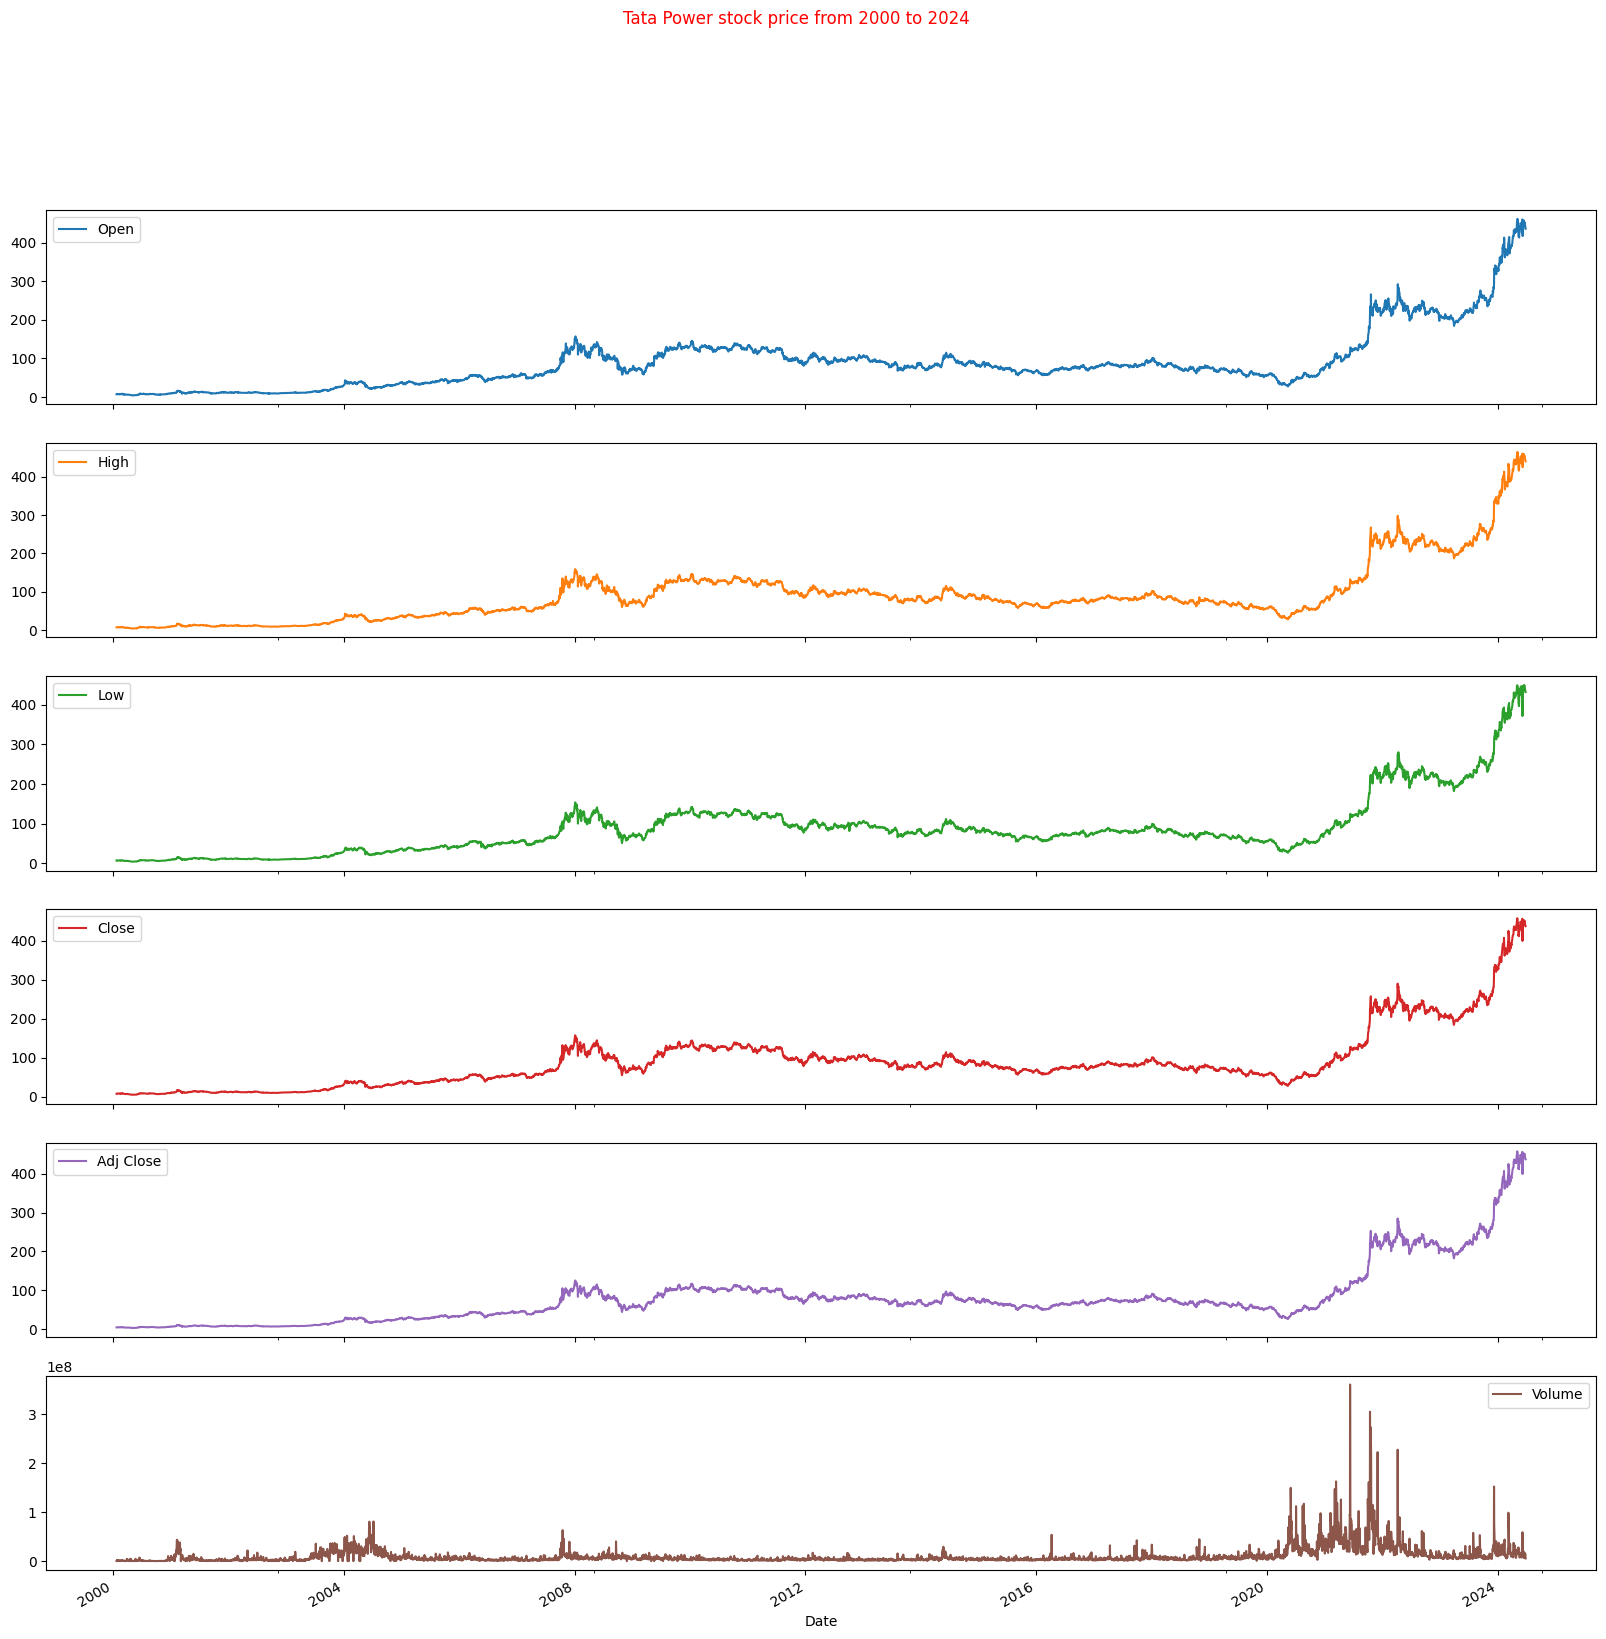

In [6]:
dataset.plot(subplots=True, figsize=(20,20))
plt.suptitle('Tata Power stock price from 2000 to 2024',color="Red")
plt.savefig('Tata_Power_stocks.png')
plt.show()

In [7]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Tata Power Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Tata Power Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Tata Power Stock Price')
    plt.title('Tata Power Stock Price Prediction')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))


In [8]:
training_set = dataset[:'2022'].iloc[:,1:2].values
test_set = dataset['2023':].iloc[:,1:2].values

In [9]:
print(training_set.shape)
print(test_set.shape)

(5730, 1)
(361, 1)


In [10]:
test_set.shape[0] / dataset.shape[0]

0.05926777212280414

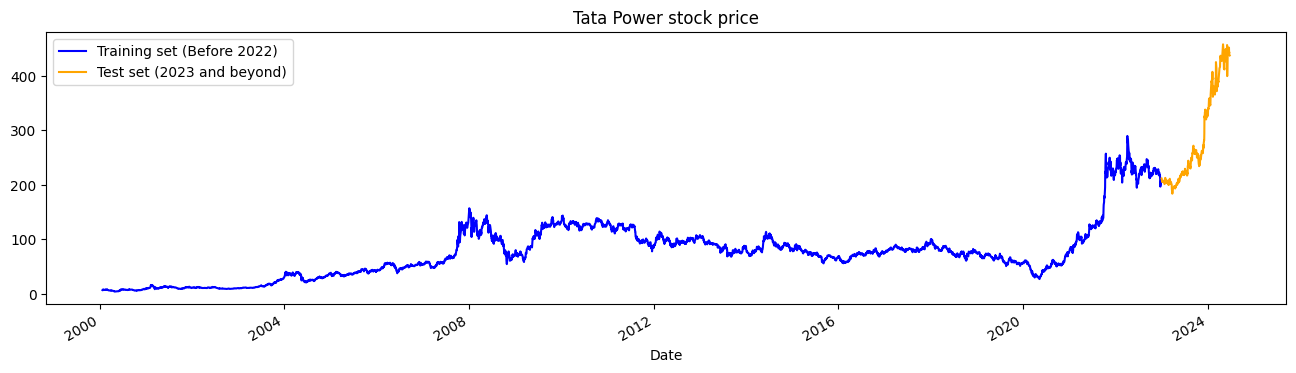

In [11]:
dataset["Close"][:'2022'].plot(figsize=(16,4),legend=True,color='b')
dataset["Close"]['2023':].plot(figsize=(16,4),legend=True,color='Orange')
plt.legend(['Training set (Before 2022)','Test set (2023 and beyond)'])
plt.title('Tata Power stock price')
plt.show()

In [12]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [13]:
training_set

array([[  7.623635],
       [  7.662236],
       [  7.662236],
       ...,
       [210.300003],
       [208.800003],
       [210.      ]])

In [14]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,training_set.shape[0]):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [15]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [16]:
X_train.shape

(5670, 60, 1)

In [ ]:
regressor = Sequential()
regressor.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='rmsprop',loss='mean_squared_error')

regressor.fit(X_train,y_train,epochs=50,batch_size=32)




Epoch 1/50


2025-09-01 15:14:35.212214: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 89ms/step - loss: 0.0099
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - loss: 0.0025
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 87ms/step - loss: 0.0018
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 88ms/step - loss: 0.0016
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step - loss: 0.0016
Epoch 6/50
136/178 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0013

In [ ]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which
#is impossible to get unless we take the whole
# 'Close' attribute data for processing
dataset_total = pd.concat((dataset["Close"][:'2022'],dataset["Close"]['2023':]),axis=0)
test_inputs = dataset_total[len(dataset_total)-len(test_set)-60:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = sc.transform(test_inputs)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,test_inputs.shape[0]):
    X_test.append(test_inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

In [ ]:
test_set.mean()

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=16)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,test_inputs.shape[0]):
    X_test.append(test_inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)